# LSTM with Tweet Volume

In [60]:
import math
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers
from mongo_db import MongoDB

def createTrainingData(dataset: pd.Series):
    training_data_len = math.ceil(len(dataset.values)* 0.8)
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_data = scaler.fit_transform(dataset.values.reshape(-1,1))
    train_data = scaled_data[0: training_data_len, :]

    x_train = []
    y_train = []

    for i in range(48, len(train_data)):
        x_train.append(train_data[i-48:i, 0])
        y_train.append(train_data[i, 0])
        
    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    
    return x_train, y_train, training_data_len, scaled_data, scaler

def createTestData(scaled_data: pd.Series, training_data_len, values):
    test_data = scaled_data[training_data_len-48: , : ]
    x_test = []
    y_test = values[training_data_len:]

    for i in range(48, len(test_data)):
        x_test.append(test_data[i-48:i, 0])

    x_test = np.array(x_test)
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
    
    return x_test, y_test

tweets = pd.read_csv('analzyed.csv', sep=',')
pricedata = pd.read_csv('lrc_snapshot_2_Nov_9_15.csv', sep=',')

Text(0, 0.5, 'Sentiment')

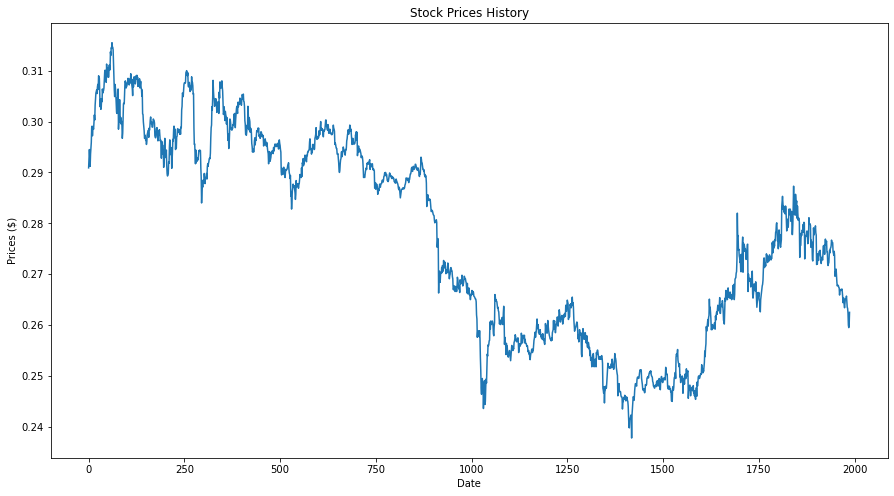

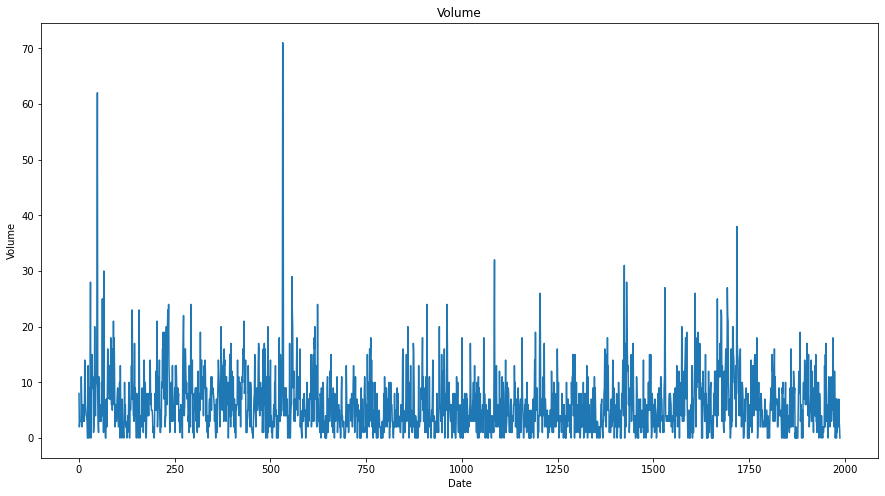

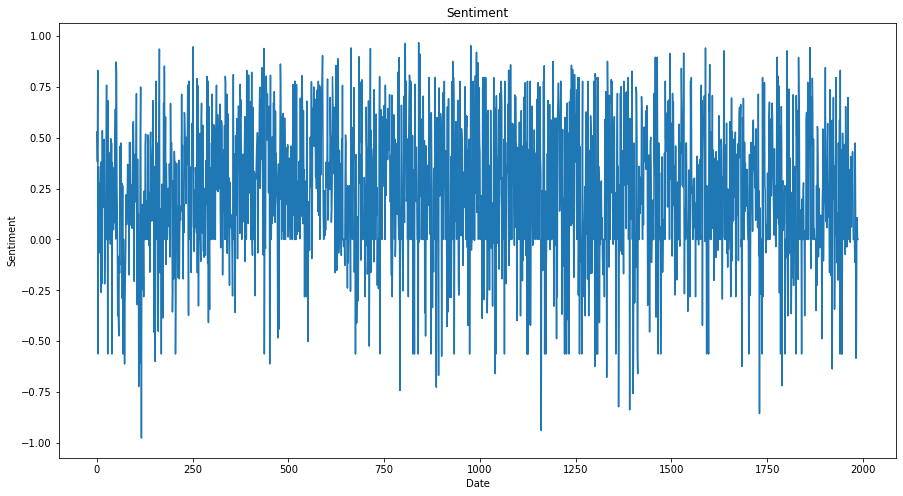

In [61]:
price_data_numeric = pd.to_numeric(pricedata['price'])
volume_numeric = pd.to_numeric(tweets['Volume'])
sentiment_numeric = pd.to_numeric(tweets['Sentiment'])

plt.figure(figsize=(15, 8))
plt.title('Stock Prices History')
plt.plot(price_data_numeric)
plt.xlabel('Date')
plt.ylabel('Prices ($)')

plt.figure(figsize=(15, 8))
plt.title('Volume')
plt.plot(volume_numeric)
plt.xlabel('Date')
plt.ylabel('Volume')

plt.figure(figsize=(15, 8))
plt.title('Sentiment')
plt.plot(sentiment_numeric)
plt.xlabel('Date')
plt.ylabel('Sentiment')

In [67]:
x_train_volume, y_train_volume, training_data_len_volume, scaled_data_volume, scaler = createTrainingData(volume_numeric)
x_train_price, y_train_price, training_data_len_price, scaled_data_price, scaler = createTrainingData(price_data_numeric)
x_train_sentiment, y_train_sentiment, training_data_len_sentiment, scaled_data_sentiment, scaler = createTrainingData(sentiment_numeric)

x_test_volume, y_test_volume = createTestData(scaled_data_volume, training_data_len_volume, volume_numeric)
x_test_price, y_test_price = createTestData(scaled_data_price, training_data_len_price, price_data_numeric)
x_test_sentiment, y_test_sentiment = createTestData(scaled_data_sentiment, training_data_len_sentiment, sentiment_numeric)

print(x_train_volume)
print(x_test_price)
print(x_test_sentiment)

input1 = layers.Input(shape=(x_train_price.shape[1], 1))
input2 = layers.Input(shape=(x_train_volume.shape[1], 1))
input3 = layers.Input(shape=(x_train_sentiment.shape[1], 1))
input = keras.layers.Concatenate()([input1, input2, input3])
lstm_layer1 = layers.LSTM(100, return_sequences=True)(input)
lstm_layer2 = layers.LSTM(100, return_sequences=False)(lstm_layer1)
dense_layer_1 = layers.Dense(25)(lstm_layer2)
output = layers.Dense(1)(dense_layer_1)
model = keras.models.Model(inputs=[input1, input2, input3], outputs=output)

model.summary()

[[[0.11267606]
  [0.02816901]
  [0.04225352]
  ...
  [0.14084507]
  [0.14084507]
  [0.30985915]]

 [[0.02816901]
  [0.04225352]
  [0.04225352]
  ...
  [0.14084507]
  [0.30985915]
  [0.87323944]]

 [[0.04225352]
  [0.04225352]
  [0.04225352]
  ...
  [0.30985915]
  [0.87323944]
  [0.09859155]]

 ...

 [[0.05633803]
  [0.09859155]
  [0.11267606]
  ...
  [0.23943662]
  [0.09859155]
  [0.26760563]]

 [[0.09859155]
  [0.11267606]
  [0.04225352]
  ...
  [0.09859155]
  [0.26760563]
  [0.09859155]]

 [[0.11267606]
  [0.04225352]
  [0.11267606]
  ...
  [0.26760563]
  [0.09859155]
  [0.04225352]]]
[[[0.18790219]
  [0.15444015]
  [0.15958816]
  ...
  [0.10553411]
  [0.14157014]
  [0.13127413]]

 [[0.15444015]
  [0.15958816]
  [0.14028314]
  ...
  [0.14157014]
  [0.13127413]
  [0.13899614]]

 [[0.15958816]
  [0.14028314]
  [0.15444015]
  ...
  [0.13127413]
  [0.13899614]
  [0.15444015]]

 ...

 [[0.48005148]
  [0.48133848]
  [0.48648649]
  ...
  [0.32818533]
  [0.31660232]
  [0.28571429]]

 [[0.481

In [68]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit([x_train_price, x_train_volume, x_train_sentiment], y_train_price, batch_size = 16, epochs=100, validation_data=([x_train_price, x_train_volume, x_train_sentiment], y_train_price))

Epoch 1/100
97/97 [==============================] - 4s 27ms/step - loss: 0.0111 - val_loss: 0.0013
Epoch 2/100
97/97 [==============================] - 2s 23ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 3/100
97/97 [==============================] - 2s 23ms/step - loss: 0.0010 - val_loss: 8.2612e-04
Epoch 4/100
97/97 [==============================] - 2s 22ms/step - loss: 8.8404e-04 - val_loss: 7.5158e-04
Epoch 5/100
97/97 [==============================] - 2s 23ms/step - loss: 8.4168e-04 - val_loss: 8.7958e-04
Epoch 6/100
97/97 [==============================] - 2s 23ms/step - loss: 8.3693e-04 - val_loss: 6.2452e-04
Epoch 7/100
97/97 [==============================] - 2s 23ms/step - loss: 6.4855e-04 - val_loss: 5.6465e-04
Epoch 8/100
97/97 [==============================] - 2s 24ms/step - loss: 6.3545e-04 - val_loss: 6.2202e-04
Epoch 9/100
97/97 [==============================] - 3s 27ms/step - loss: 6.7600e-04 - val_loss: 5.1927e-04
Epoch 10/100
97/97 [============================

In [69]:
predictions = model.predict((x_test_price, x_test_volume, x_test_sentiment))
predictions = scaler.inverse_transform(predictions)
print(predictions)
rmse = np.sqrt(np.mean(predictions[0] - y_test_price)**2)
rmse

13/13 [==============================] - 0s 8ms/step
[[-7.42268145e-01]
 [-7.28999436e-01]
 [-6.94050670e-01]
 [-6.98275805e-01]
 [-6.95228040e-01]
 [-7.01965272e-01]
 [-7.02702582e-01]
 [-6.91783726e-01]
 [-7.00126827e-01]
 [-7.02181518e-01]
 [-7.03241289e-01]
 [-6.63093507e-01]
 [-6.67568386e-01]
 [-6.64186120e-01]
 [-6.70843780e-01]
 [-6.67281330e-01]
 [-6.70454979e-01]
 [-6.61514103e-01]
 [-6.35004282e-01]
 [-5.90983212e-01]
 [-6.03675544e-01]
 [-5.69543958e-01]
 [-5.52259386e-01]
 [-4.80427295e-01]
 [-4.86850709e-01]
 [-4.68703479e-01]
 [-4.47729528e-01]
 [-4.29216862e-01]
 [-4.54791903e-01]
 [-4.20831382e-01]
 [-4.09205288e-01]
 [-3.39154541e-01]
 [-3.69498253e-01]
 [-3.63273293e-01]
 [-3.85679394e-01]
 [-4.16001827e-01]
 [-4.58768636e-01]
 [-4.62829322e-01]
 [-4.66621608e-01]
 [-4.50649649e-01]
 [-4.64315981e-01]
 [-4.56051439e-01]
 [-4.52981383e-01]
 [-4.49267238e-01]
 [-4.37946081e-01]
 [-4.38158542e-01]
 [-4.62638557e-01]
 [-4.13805038e-01]
 [-4.22659039e-01]
 [-3.94843251e-0

1.0129394297191425

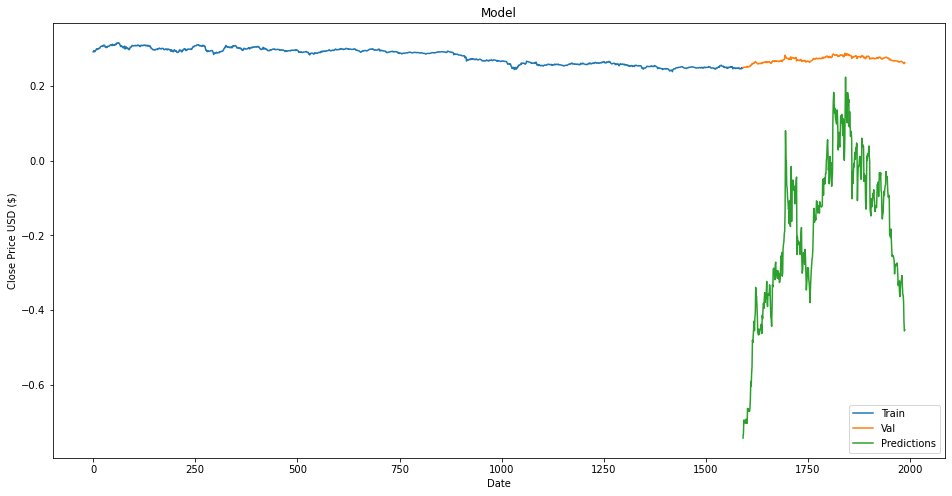

In [70]:
data = price_data_numeric
train = data[:training_data_len_price]
validation = pd.DataFrame()
validation['price'] = data[training_data_len_price:]
validation['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train)
plt.plot(validation[['price', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

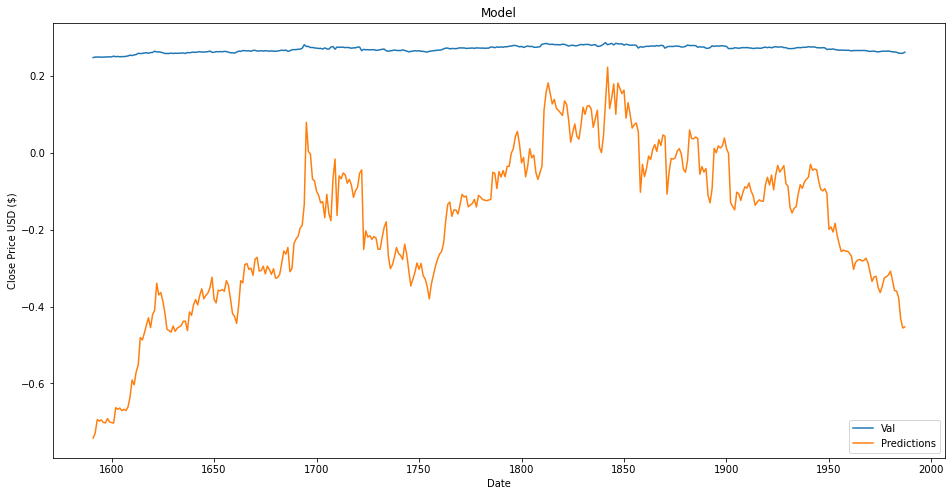

In [71]:
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(validation[['price', 'Predictions']])
plt.legend(['Val', 'Predictions'], loc='lower right')
plt.show()